## Compressing images using the singular value decomposition

This notebook explains how the SVD can be used to compress image data.

*For questions / bugs / suggestions, please contact me @ christoph.glanzer@ifor.math.ethz.ch*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from io import BytesIO

We begin by loading the image and calculating the SVD. Feel free to try out different images. For simplicity, we transform the image to grayscale. The same approach works with colored images by applying the compression to each channel (each color) separately.

In [2]:
# Image by Ali Taylor, https://www.freeimages.com/photo/close-squirrel-1381764
url = "https://images.freeimages.com/images/large-previews/1cb/close-squirrel-1381764.jpg"
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert('L')

# Create a numpy array from the image
imagemat = np.array(image)

# Calculate the SVD
# This might take a while.
# Note: S is a vector, not a matrix.
[U,S,V] = np.linalg.svd(imagemat, full_matrices=True)
print(f"There are {len(S) - sum([np.isclose(x,0,atol=1e-3) for x in S])} non-zero singular values.")

There are 1200 non-zero singular values.


The singular values are sorted by size, i.e., $\sigma_1 \geq \sigma_2 \geq \ldots \geq \sigma_n$. Now, the idea is the following: Starting from a certain index, we set all singular values to zero. This significantly reduces the space needed to store the image data: Many of the entries of $U$ and $V$ are not involved in the matrix multiplication anymore and can therefore be dropped as well.

In other words, we can write the SVD of the input matrix (image) $A \in \mathbb{Q}^{m \times n}$ as a sum of rank-1-matrices as follows:
\begin{align}
A = U \Sigma V^\mathrm{T} = \sum_{i=1}^{\min\{n,m\}} \sigma_i u_i v_i^T,
\end{align}
where $u_i$ and $v_i$ are the left and right singular vectors, respectively (i.e., the column-vectors of $U$ and $V$). Now, starting from a certain index, we drop the remaining summands. 

In the following code, feel free to try out different values of K, the number of singular values kept in the compressed image.

Text(0.5, 1.0, 'Compressed: 112040 float values.')

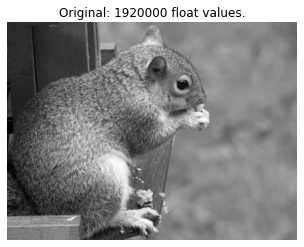

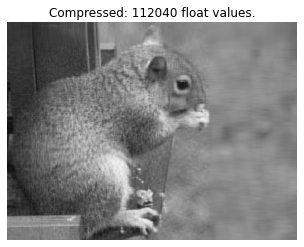

In [3]:
# ** Adapt the number of singular values kept here! **
K = 40

# Drop all other singular values
SCrop = np.copy(S)
SCrop[K+1:] = 0

# Reconstruct the image
# Construct matrix 'S' of correct shape
smat = np.zeros((U.shape[1], V.shape[1]))
smat[:U.shape[1], :U.shape[1]] = np.diag(SCrop)
newim = U @ smat @ V

# Plot and compare
plt.figure()
plt.imshow(imagemat, cmap="gray")
plt.axis("off")
plt.title("Original: " + str(imagemat.shape[0] * imagemat.shape[1]) + " float values.")

plt.figure()
plt.imshow(newim, cmap="gray")
plt.axis("off")
plt.title("Compressed: " + str(K * (1 + U.shape[0] + V.shape[1])) + " float values.")